## LSTM 이용한 삼성전자 주가 예측

In [ ]:
순환 신경망(Recurrent Neural Network, RNN)
- DFN의 시계열 데이터 처리의 한계점 해결하기 위한 신경망
- 유닛 간 연결이 순환적 구조를 이룸
- 신경망 내부에 상태를 저장할 수 있게 함으로써
- 내부의 메모리를 이용해 시퀀스 형태의 입력 처리
- 문자열, 센서 데이터, 음성인식과 같이 시간적으로 연속성이 있는 데이터 처리에 용이
- 층이 많은 네트워크에서 나타나는 그래디언트 소실 문제(vanishing gradient problem) 발생
- 오랜 시간에 결쳐 학습시 gradient가 소실하는 문제

- 여러 개의 데이터가 순서대로 입력되었을 때 
- 앞서 입력받은 데이터를 잠시 기억해 놓는 방법
- 기억된 데이터가 얼마나 중요한지를 판단하여 
- 별도의 가중치를 줘서 다음 데이터로 넘어감
- 모든 입력 값에 이 작업을 순서대로 실행하므로 
- 다음 층으로 넘어가기 전에 같은 층을 맴도는 것처럼 보임

In [ ]:
Long Short-Term Memory (LSTM)
- RNN에서 발생하는 그래디언트 소실 문제를 해결하기 위해 제안
- 한 층 안에서 반복을 많이 해야 하는 RNN의 특성상 
- 일반 신경망보다 기울기 소실 문제가 더 많이 살행하고
- 이를 보완하기 위한 방법
- 즉, 반복되기 직전에 다음 층으로 
- 기억된 값을 넘길지 안 넘길지를 관리하는 단계를 하나 더 추가

In [1]:
import pandas as pd
import numpy as np

In [72]:
df = pd.read_csv('./data/01-삼성전자-주가.csv', encoding='utf8')
df

,일자,시가,고가,저가,종가,거래량
0,20200107,55700,56400,55600,55800,9893846
1,20200106,54900,55600,54600,55500,10278951
2,20200103,56000,56600,54900,55500,15422255
3,20200102,55500,56000,55000,55200,12993228
4,20191230,56200,56600,55700,55800,8356767
...,...,...,...,...,...,...
9283,19850109,126,126,122,123,324836
9284,19850108,129,129,127,127,845098
9285,19850107,129,130,128,129,771895
9286,19850105,129,129,128,128,108496


In [6]:
df.info()
# 일자 : 정수형
# ---> 날짜형으로 변환

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9288 entries, 0 to 9287
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   일자      9288 non-null   int64
 1   시가      9288 non-null   int64
 2   고가      9288 non-null   int64
 3   저가      9288 non-null   int64
 4   종가      9288 non-null   int64
 5   거래량     9288 non-null   int64
dtypes: int64(6)
memory usage: 435.5 KB


In [73]:
df['일자'] = pd.to_datetime(df['일자'], format='%Y%m%d')
df

,일자,시가,고가,저가,종가,거래량
0,2020-01-07,55700,56400,55600,55800,9893846
1,2020-01-06,54900,55600,54600,55500,10278951
2,2020-01-03,56000,56600,54900,55500,15422255
3,2020-01-02,55500,56000,55000,55200,12993228
4,2019-12-30,56200,56600,55700,55800,8356767
...,...,...,...,...,...,...
9283,1985-01-09,126,126,122,123,324836
9284,1985-01-08,129,129,127,127,845098
9285,1985-01-07,129,130,128,129,771895
9286,1985-01-05,129,129,128,128,108496


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9288 entries, 0 to 9287
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   일자      9288 non-null   datetime64[ns]
 1   시가      9288 non-null   int64         
 2   고가      9288 non-null   int64         
 3   저가      9288 non-null   int64         
 4   종가      9288 non-null   int64         
 5   거래량     9288 non-null   int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 435.5 KB


In [ ]:
#######################  거래량 확인 ###########################

In [9]:
df.describe()

,시가,고가,저가,종가,거래량
count,9288.000000,9288.000000,9288.000000,9288.000000,9.288000e+03
mean,11108.556417,11228.754522,10986.106481,11108.235465,1.645823e+07
std,13792.646300,13920.105135,13658.809496,13790.922497,1.701535e+07
min,116.000000,116.000000,115.000000,116.000000,0.000000e+00
25%,624.000000,632.000000,620.000000,623.000000,3.833986e+06
50%,5045.000000,5190.000000,4955.000000,5075.000000,1.199608e+07
75%,15920.000000,16050.000000,15740.000000,15920.000000,2.284080e+07
max,57500.000000,57520.000000,56760.000000,57220.000000,3.266220e+08


In [ ]:
거래량이 0이 존재
--> 0을 NaN을 변경
--> dropna()

In [10]:
df['거래량'] = df['거래량'].replace(0, np.nan)
df.isnull().sum()

일자     0
시가     0
고가     0
저가     0
종가     0
거래량    4
dtype: int64

In [11]:
df[df['거래량'].isnull() == True]

,일자,시가,고가,저가,종가,거래량
410,2018-05-03,53000,53000,53000,53000,NaN
411,2018-05-02,53000,53000,53000,53000,NaN
412,2018-04-30,53000,53000,53000,53000,NaN
8701,1987-01-05,419,419,419,419,NaN


In [12]:
df = df.dropna()
df.isnull().sum()

일자     0
시가     0
고가     0
저가     0
종가     0
거래량    0
dtype: int64

In [ ]:
#######################  거래량 0 값 제거 끝 ###########################

### 1990년도 이후의 주가

In [74]:
df_1990 = df.loc[df['일자'].dt.year >= 1990]
df_1990

,일자,시가,고가,저가,종가,거래량
0,2020-01-07,55700,56400,55600,55800,9893846
1,2020-01-06,54900,55600,54600,55500,10278951
2,2020-01-03,56000,56600,54900,55500,15422255
3,2020-01-02,55500,56000,55000,55200,12993228
4,2019-12-30,56200,56600,55700,55800,8356767
...,...,...,...,...,...,...
7823,1990-01-08,681,687,673,673,966666
7824,1990-01-06,685,689,681,681,1724183
7825,1990-01-05,689,693,678,678,1790849
7826,1990-01-04,689,701,685,693,2738562


In [ ]:
# 1990년도 이후의 주가 시각화

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [76]:
# 한글 문제
# matplotlib의 기본 폰트에서 한글이 지원되지 않기 때문에
# matplotlib의 폰트 변경 필요
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')

Text(0, 0.5, '종가')

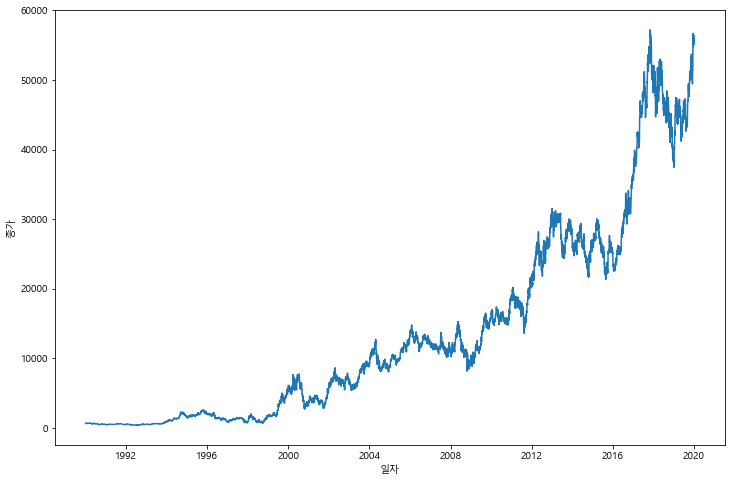

In [77]:
plt.figure(figsize=(12,8))
sns.lineplot(y=df_1990['종가'], x=df_1990['일자'])

plt.xlabel('일자')
plt.ylabel('종가')

### MinMaxScaler 사용해서 정규화

In [78]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래량']
scaled_1990 = scaler.fit_transform(df_1990[scale_cols]) # 배열

df_1990_scaled = pd.DataFrame(scaled_1990)
df_1990_scaled.columns = scale_cols

print(df_1990_scaled)

            시가        고가        저가        종가       거래량
0     0.968482  0.980394  0.979423  0.975012  0.030291
1     0.954474  0.966389  0.961684  0.969733  0.031470
2     0.973735  0.983895  0.967005  0.969733  0.047217
3     0.964980  0.973391  0.968779  0.964454  0.039781
4     0.977237  0.983895  0.981197  0.975012  0.025585
...        ...       ...       ...       ...       ...
7823  0.005095  0.005094  0.005073  0.004927  0.002960
7824  0.005165  0.005129  0.005215  0.005068  0.005279
7825  0.005236  0.005199  0.005162  0.005015  0.005483
7826  0.005236  0.005339  0.005286  0.005279  0.008384
7827  0.004955  0.005129  0.004860  0.005138  0.005251

[7828 rows x 5 columns]


In [20]:
scaled_1990

array([[0.96848188, 0.98039353, 0.97942277, 0.97501188, 0.02995173],
       [0.95447382, 0.96638891, 0.96168378, 0.9697327 , 0.03113119],
       [0.9737349 , 0.98389469, 0.96700548, 0.9697327 , 0.04688367],
       ...,
       [0.00523551, 0.00519922, 0.00516205, 0.00501522, 0.00513455],
       [0.00523551, 0.00533926, 0.00528622, 0.00527918, 0.00803713],
       [0.00495535, 0.00512919, 0.00486048, 0.0051384 , 0.00490234]])

In [21]:
df_1990_scaled

,시가,고가,저가,종가,거래량
0,0.968482,0.980394,0.979423,0.975012,0.029952
1,0.954474,0.966389,0.961684,0.969733,0.031131
2,0.973735,0.983895,0.967005,0.969733,0.046884
3,0.964980,0.973391,0.968779,0.964454,0.039444
4,0.977237,0.983895,0.981197,0.975012,0.025244
...,...,...,...,...,...
7820,0.005095,0.005094,0.005073,0.004927,0.002610
7821,0.005165,0.005129,0.005215,0.005068,0.004930
7822,0.005236,0.005199,0.005162,0.005015,0.005135
7823,0.005236,0.005339,0.005286,0.005279,0.008037


### 학습용 데이터 셋 생성

In [ ]:
학습용 데이터 셋
- 과거 20일 기반으로 내일 데이터 예측
- window_size = 20

학습용 데이터 : 과거부터 ~ 200일 이전 데이터
검증용(테스트용) 데이터 : 이후 200일의 데이터
TEST_SIZE = 200

In [79]:
TEST_SIZE = 200
train = df_1990_scaled[:-TEST_SIZE]
test = df_1990_scaled[-TEST_SIZE:]

In [23]:
train # 7625 행

,시가,고가,저가,종가,거래량
0,0.968482,0.980394,0.979423,0.975012,0.029952
1,0.954474,0.966389,0.961684,0.969733,0.031131
2,0.973735,0.983895,0.967005,0.969733,0.046884
3,0.964980,0.973391,0.968779,0.964454,0.039444
4,0.977237,0.983895,0.981197,0.975012,0.025244
...,...,...,...,...,...
7620,0.001751,0.001716,0.001827,0.001707,0.001059
7621,0.001856,0.001768,0.001827,0.001707,0.001762
7622,0.001856,0.001751,0.001792,0.001813,0.005727
7623,0.001874,0.001768,0.001792,0.001813,0.007569


In [24]:
test # 200 행

,시가,고가,저가,종가,거래량
7625,0.002014,0.002048,0.001934,0.001813,0.001629
7626,0.001751,0.001873,0.001738,0.001936,0.002340
7627,0.001628,0.001646,0.001703,0.001584,0.001015
7628,0.001558,0.001716,0.001632,0.001584,0.009238
7629,0.002119,0.002013,0.001898,0.001777,0.002314
...,...,...,...,...,...
7820,0.005095,0.005094,0.005073,0.004927,0.002610
7821,0.005165,0.005129,0.005215,0.005068,0.004930
7822,0.005236,0.005199,0.005162,0.005015,0.005135
7823,0.005236,0.005339,0.005286,0.005279,0.008037


In [80]:
# 시계열 데이터 셋 생성 함수

def make_seq_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
   
    return np.array(feature_list), np.array(label_list)

# 순차적으로 20일 동안의 데이터 셋을 묶고
# 이데 대한 label(예측값)과 함께 반환

In [81]:
# 피처 데이터셋 : feature와 label 지정

feature_cols = ['시가', '고가', '저가', '거래량']
label_col = ['종가']

train_feature = train[feature_cols]
train_label = train[label_col]

In [26]:
train_feature

,시가,고가,저가,거래량
0,0.968482,0.980394,0.979423,0.029952
1,0.954474,0.966389,0.961684,0.031131
2,0.973735,0.983895,0.967005,0.046884
3,0.964980,0.973391,0.968779,0.039444
4,0.977237,0.983895,0.981197,0.025244
...,...,...,...,...
7620,0.001751,0.001716,0.001827,0.001059
7621,0.001856,0.001768,0.001827,0.001762
7622,0.001856,0.001751,0.001792,0.005727
7623,0.001874,0.001768,0.001792,0.007569


In [27]:
train_label

,종가
0,0.975012
1,0.969733
2,0.969733
3,0.964454
4,0.975012
...,...
7620,0.001707
7621,0.001707
7622,0.001813
7623,0.001813


In [82]:
# 학습 데이터 셋 생성 : 시계열 데이터 형태 변환
train_feature, train_label = make_seq_dataset(train_feature, train_label, 20)

In [32]:
train_feature.shape # 총 7625개 중 마지막 20개 제외된 7605

(7605, 20, 4)

In [33]:
train_feature.shape[1]

20

In [34]:
train_feature.shape[2]

4

In [83]:
# 학습용, 테스트용 데이터 셋 생성

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_feature, train_label, test_size=0.2)

X_train.shape, X_test.shape

((6086, 20, 4), (1522, 20, 4))

In [84]:
# 검증용 테스트 피처 데이터 셋

feature_cols = ['시가', '고가', '저가', '거래량']
label_col = ['종가']

test_feature = test[feature_cols]
test_label = test[label_col]

test_feature.shape, test_label.shape

((200, 4), (200, 1))

In [85]:
# 검증 데이터 셋 생성 : 시계열 데이터 형태 변환
test_feature, test_label = make_seq_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((180, 20, 4), (180, 1))

### LSTM 모델 생성

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM

model = Sequential()

model.add(LSTM(128,
              input_shape=(train_feature.shape[1], train_feature.shape[2]),
              activation='relu', # activation='tanh', relu
              return_sequences=False)
         )

model.add(Dense(1))

# 케라스에서는 층(layer)을 조합해서 모델(model) 생성
# 가장 간단한 형태의 모델은 레이어들을 선형으로 쌓는 Sequential Model
# 케라스에서는 add() 함수를 사용하여 층을 쌓음

# LSTM 레이어와 Dense 레이어로 구성
# - 16 메모리 셀을 가진 LSTM 레이어 한 개
# - Dense 레이어 한 개(output)

# Dense 레이는 완전 연결 레이어로 기본적인 레이어 중 하나
# 예측하고 하는 target 개수가 하나이므로 Dense(1) 출력으로 사용
# 케라스에서는 input이 어떤 모양으로 들어올지 대한 정보가 필요
# input_shape : (20, 4) : 20행 4열 

# train_feature.shape : (7605, 20, 4) : 3차원 데이터
# train_feature.shape[1] : 20
# train_feature.shape[2] : 4

# LSTM 층
# RNN에서 기억 값에 대한 갸중치를 제어하며
# 활성화 함수로는 tanh(하이퍼볼릭 탄젠트)를 사용
# Vanishing gradient 문제를 예방하기 위해
# gradient가 최대한 오래 유지될 수 있도록 해주는 역할로
# tanh가 적합하기 때문 

In [87]:
# 컴파일 
model.compile(loss='mean_squared_error', optimizer='adam')
# loss : 최적화 과정에서 최소화될 손실 함수(loss funcion) 설정
# optimizer : 학습 과정 설정

# 조기 중단 설정
early_stop = EarlyStopping(monitor='val_loss', patience=5)

checkpoint = ModelCheckpoint('./temp_checkpoint.h5',
                            monitor='val_loss', verbose=1,
                            save_best_only=True, mode='auto')

history = model.fit(X_train, y_train,
                   epochs=200,
                   batch_size=16,
                   validation_data=(X_test, y_test),
                   callbacks=[early_stop, checkpoint])

Epoch 1/200
379/381 [============================>.] - ETA: 0s - loss: 0.0024
Epoch 00001: val_loss improved from inf to 0.00009, saving model to .\temp_checkpoint.h5
381/381 [==============================] - 3s 9ms/step - loss: 0.0024 - val_loss: 9.1142e-05
Epoch 2/200
377/381 [============================>.] - ETA: 0s - loss: 9.5967e-05
Epoch 00002: val_loss improved from 0.00009 to 0.00008, saving model to .\temp_checkpoint.h5
381/381 [==============================] - 3s 8ms/step - loss: 9.5936e-05 - val_loss: 7.8575e-05
Epoch 3/200
376/381 [============================>.] - ETA: 0s - loss: 8.6926e-05
Epoch 00003: val_loss improved from 0.00008 to 0.00007, saving model to .\temp_checkpoint.h5
381/381 [==============================] - 3s 8ms/step - loss: 8.6460e-05 - val_loss: 6.7732e-05
Epoch 4/200
377/381 [============================>.] - ETA: 0s - loss: 7.2378e-05
Epoch 00004: val_loss improved from 0.00007 to 0.00006, saving model to .\temp_checkpoint.h5
381/381 [============

In [69]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               68096     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 68,225
Trainable params: 68,225
Non-trainable params: 0
_________________________________________________________________


In [88]:
# 저장한 모델 로드하고 예측
model.load_weights('./temp_checkpoint.h5')

# 예측
pred = model.predict(test_feature)
# 시계열 데이터 형대로 입력

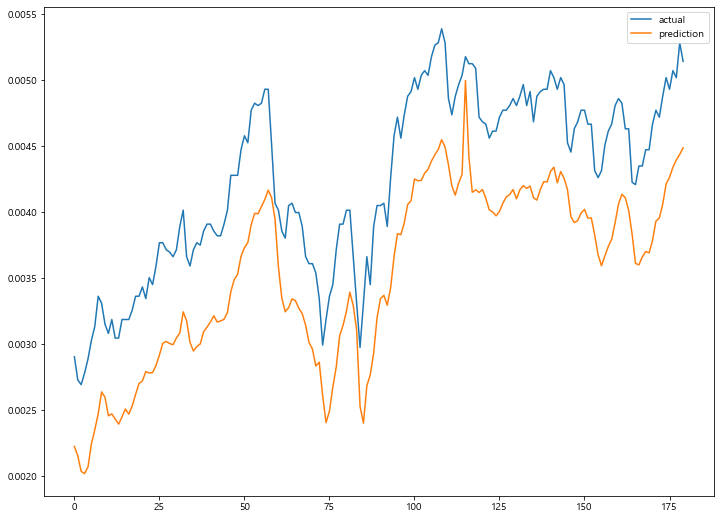

In [71]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

# LSTM(128
# activation='relu',

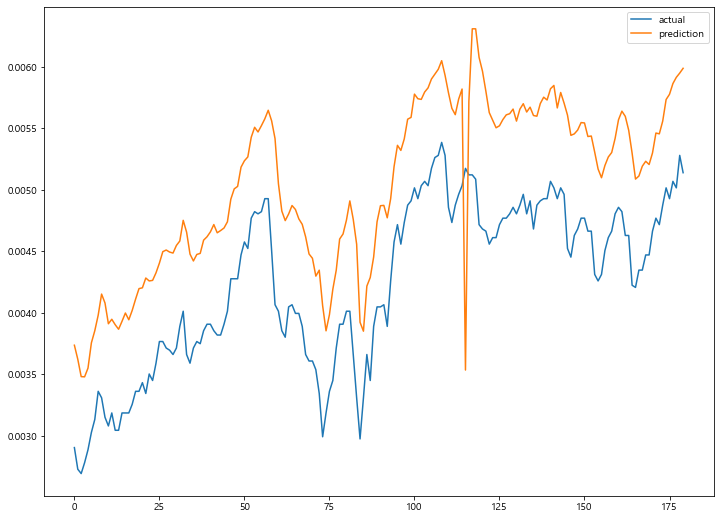

In [66]:
# 실제 데이터와 예측 데이터 시각화

plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

# LSTM(128
# activation='tanh',

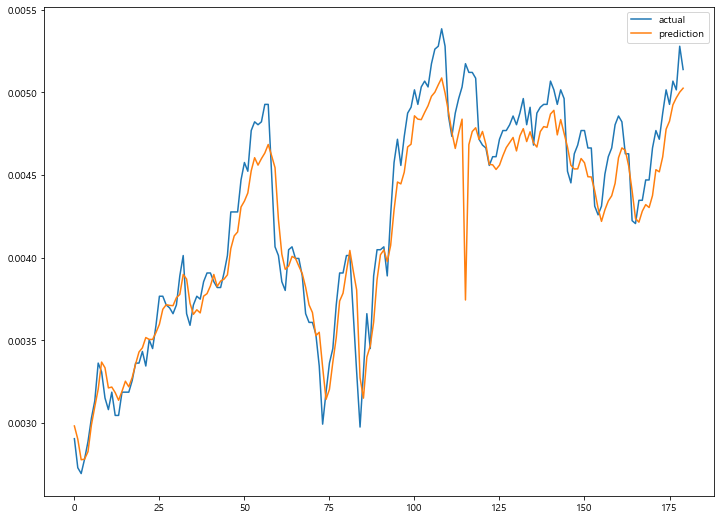

In [89]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

# LSTM(128
# activation='relu',
# 거래량 0인 값을 NaN으로 변경해서 제거하지 않은 데이터